# Modelling Simple Harmonic Jitter
The goal here is to model the effect of jitter (instability in the pointing of a telescope) on the image. Here we will assume that the telescope is vibrating at high frequency back and forth in one-dimension, following a simple harmonic motion. One would expect the result of this jitter to appear like a blur with two peaks at the extremity of its excursion, as that is the position at which the detector spends the most time during its exposure. Let us derive analytically what that function looks like.

## Deriving the analytic form of convolution kernel.

For now, let's just work in one-dimension. Eventually we are going to want to model this by creating a convolution kernel of this weird peaky function, and convolve it with our stable image. So one-dimension works for now, as we can extrapolate to two-dimensions by hitting our one-dimensional result with a rotation matrix.

The telescope point is varying according to simple harmonic motion (SHM):

$$ x(t) = A\sin(t), $$

with inverse function (will be important later):

$$ t(x) = \arcsin(x/A). $$

We will ignore the frequency as we are assuming a single period is significantly shorter than the detector integration time. The convolution kernel will be the probability distribution function (PDF) of this SHM. This makes sense, as the PDF is proportional to how long the telescope spends in each part of the oscillation path. 

We can consider a random variable $X$, representing the position of telescope pointing, which has a PDF of $f(x)$:

$$ P(-A < X < A) = \int_{-A}^{A}f(x) \, dx = A\sin(t). $$

We want to find this function $f(x)$. Since we consider the income of photons to be approximately uniform in time, we can consider a uniform random variable $T$ representing the time sampling. Given $T$ is uniformly sampled, $T$ will have a PDF of $g(t)=1/\pi$, as $\pi$ is the range of defined outputs of $t(x)$, and thus the _domain_ of $g(t(x))$. We can write:

$$ P(t_1 < T < t_2) = \int_{t_1}^{t_2} g(t) \, dt = \frac{1}{2\pi}\int_{t_1}^{t_2} dt. $$ 

One can transform PDFs using [the following rule](https://www.cl.cam.ac.uk/teaching/2003/Probability/prob11.pdf):

$$ f(x) = g(t(x))\left|{\frac{dt}{dx}}\right|. $$

Substituting in $g(t)=1/\pi$ and given the [derivative of $ \arcsin(x/A) $](https://www.google.com/), we are left with:

$$ f(x) = \frac{1}{\pi\sqrt{A^2 - x^2}}. $$

Great. This equation is our PDF of the telescope pointing position, and thus the functional form of our desired convolution kernel. For the visual learners in the audience, let's generate some uniformly distributed time samples over and pass them through our $x(t)$ function to convince ourselves it is the correct form. We can plot the histogram and overplot the analytic PDF to compare them.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

Let's define our $x(t)$ and $f(x)$ functions.

In [40]:
# Simple harmonic motion
def x(t, A):
    return A*np.sin(t)

# derived probability density function
def f(x, A):
    return 1/(np.pi*np.sqrt(A**2 - x**2))

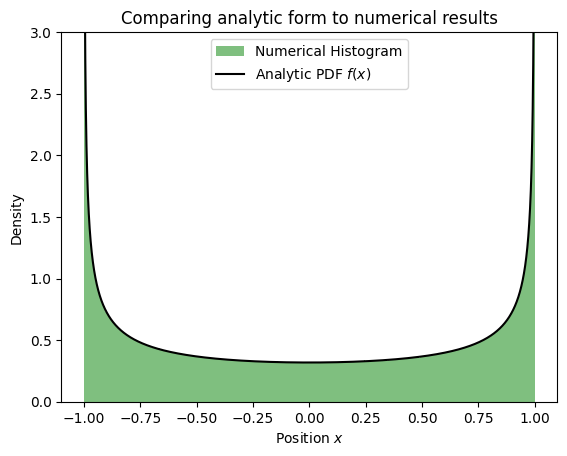

In [77]:
A = 1  # arbitrarily choosing an oscillation amplitude

# creating samples in x and t
time_samples = np.random.uniform(-np.pi, np.pi, 10000000)
position_samples = np.linspace(-A, A, 10000)[1:-1]  # avoiding division by 0

# computing the histogram and PDF
hist_outputs = x(time_samples, A)
PDF_outputs = f(position_samples, A)

# plotting
fig, ax = plt.subplots()
ax.hist(hist_outputs, bins=500, density=True, alpha=0.5, label='Numerical Histogram', color='green')
ax.plot(position_samples, PDF_outputs, c='k', label='Analytic PDF $f(x)$')
ax.set(title="Comparing analytic form to numerical results", ylim=(None, 3), xlabel='Position $x$', ylabel='Density')
ax.legend()
plt.show()

If you are not now convinced of this functional form, there is no saving you.

## Jitter on a pixel grid -- 1D

We want to represent this function on a pixel grid -- for now let's continue the one-dimensional case, so we will consider a simple row of $n$ pixels. We will choose $n$ as the minimum number of pixels required to entirely span the oscillation amplitude. 

In [75]:
pscale = 0.19  # choosing some arbitrary pixel scale
n = int(np.ceil(2*A / pscale))  # dividing and rounding up!
print(f"npix = {n}")

npix = 11


We can use the `nd_coords` function from `dLux.utils` to find the coordinates of the pixel edges and centres. These are crucial to have, as we will see further on.

In [76]:
from dLux.utils import nd_coords

pixel_centres = nd_coords(npixels=n, pixel_scales=pscale)
pixel_edges = nd_coords(npixels=n+1, pixel_scales=pscale)

Let's visualise how our PDF lies on top of our pixel grid.

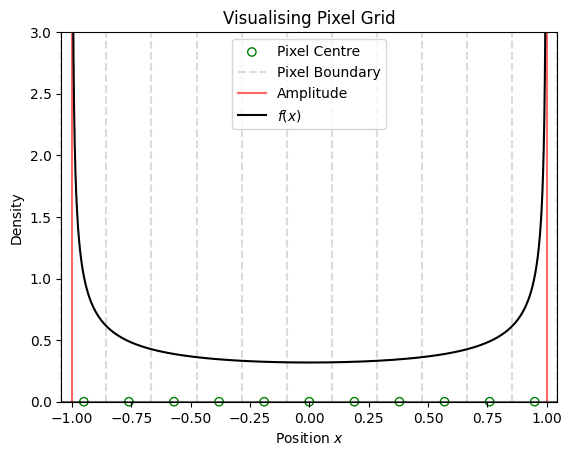

In [79]:
fig, ax = plt.subplots()
ax.scatter(pixel_centres, np.zeros(n), marker='o', facecolors='none', edgecolors='green', label="Pixel Centre", clip_on=False)
ax.axvline(pixel_edges[0], c='k', linestyle='--', alpha=0.14, label='Pixel Boundary', clip_on=False)
for edge in pixel_edges[1:]:
    ax.axvline(edge, c='k', linestyle='--', alpha=0.14, clip_on=False)
ax.axvline(A, c='r', linestyle='-', alpha=0.6, label='Amplitude')
ax.axvline(-A, c='r', linestyle='-', alpha=0.6)
ax.axhline(0, c='k', linestyle='-', alpha=0.6)
ax.plot(position_samples, PDF_outputs, c='k', label='$f(x)$')
ax.set(title="Visualising Pixel Grid", ylim=(0., 3), xlim=(-n*pscale/2, n*pscale/2), xlabel='Position $x$', ylabel='Density')
ax.legend()
plt.show()

We want to define the _flux_ of a pixel as the area under $f(x)$ contained within that pixel's boundaries. This will be done by integrating $f(x)$ over the pixel -- we can _trivially_ see from above that this integral is simply $\pi t(x)$. That is, for a pixel with bounded by $a$ and $b$:

$$ \text{flux} = \int_{a}^{b} f(x) \, dx = \pi \left[ t(x) \right]_a ^b = \pi \left[ \arcsin\left(\frac{x}{A}\right) \right]_a ^b = \pi \left( \arcsin\left(\frac{a}{A}\right) - \arcsin\left(\frac{b}{A}\right) \right)$$

This is why we needed the coordinates for our pixel boundaries. Let's define our $t(x)$ function:

In [83]:
def t(x, A):
    return np.arcsin(x/A)

And now let us compute the flux using the above formula for all pixels. A slight caveat: since $f(x)$ is not defined at the very edges of the pixel array, we will instead have to assume the left-most boundary to be $-A$ and the right-most to be $A$. This however will not change the value of the integral.

In [100]:
# Setting outer pixels to -A and A
effective_pixel_edges = pixel_edges.at[0].set(-A).at[-1].set(A)
fluxes = np.pi * (t(effective_pixel_edges[1:], A) - t(effective_pixel_edges[:-1], A))

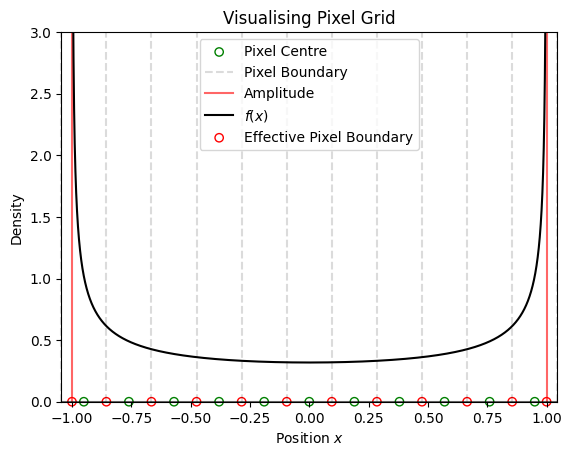

In [101]:
fig, ax = plt.subplots()
ax.scatter(pixel_centres, np.zeros(n), marker='o', facecolors='none', edgecolors='green', label="Pixel Centre", clip_on=False)
ax.axvline(pixel_edges[0], c='k', linestyle='--', alpha=0.14, label='Pixel Boundary', clip_on=False)
for edge in pixel_edges[1:]:
    ax.axvline(edge, c='k', linestyle='--', alpha=0.14, clip_on=False)
ax.axvline(A, c='r', linestyle='-', alpha=0.6, label='Amplitude')
ax.axvline(-A, c='r', linestyle='-', alpha=0.6)
ax.axhline(0, c='k', linestyle='-', alpha=0.6)
ax.plot(position_samples, PDF_outputs, c='k', label='$f(x)$')
ax.set(title="Visualising Pixel Grid", ylim=(0., 3), xlim=(-n*pscale/2, n*pscale/2), xlabel='Position $x$', ylabel='Density')

ax.legend()
plt.show()